<div style="text-align: center;">
  <h2><strong></strong></h2>
</div>

<center>

## **Prueba Técnica Novaventa**
## **Sistema de Recomendaciones: Filtrado de Colaborativo Basado en Usuarios**

**Autor:** Sebastian Carvalho Salazar  

</center>

## Librerias

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import IncrementalPCA
from scipy import sparse
import time
import numpy as np

## Rutas

In [36]:
import yaml
import os

# Obtener la ruta absoluta del archivo paths.yaml
current_dir = current_dir = os.getcwd()
config_path = os.path.join(current_dir, '..', 'Config', 'paths.yaml')

# Cargar el contenido del archivo YAML
with open(config_path, 'r') as file:
    paths = yaml.safe_load(file)

## Datos

In [37]:
path_1 = paths['StagingZone']['dataset_1']
dataset_1 = pd.read_csv(path_1, sep=";").drop(['Unnamed: 0'], axis=1)

path_2 = paths['StagingZone']['productos']
productos = pd.read_csv(path_2, sep=";").drop(['Unnamed: 0'], axis=1)

path_3 = paths['StagingZone']['user_item_matrix']
user_item_matrix = pd.read_parquet(path_3)

## Transformación

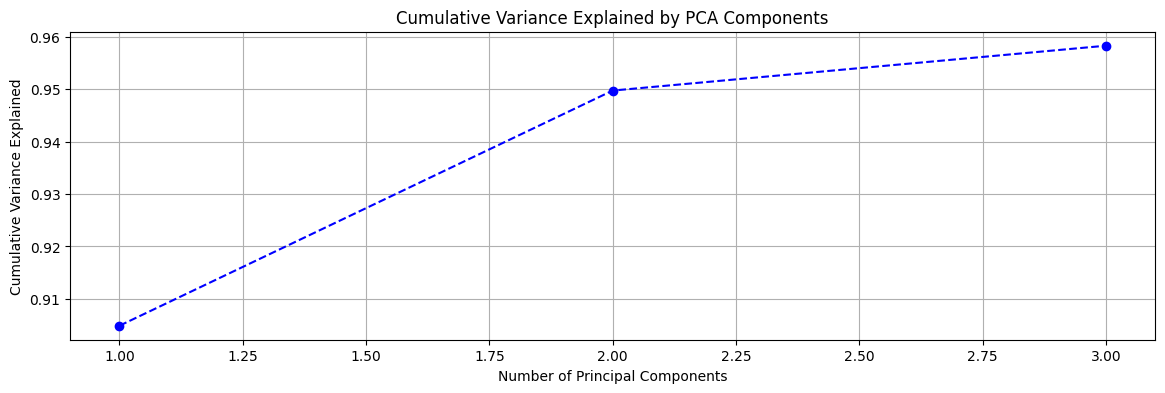

In [38]:
sparse_user_item_matrix = sparse.csr_matrix(user_item_matrix)

# Aplicar IncrementalPCA
n_components = 3    # Número de componentes principales que queremos retener
batch_size = 1000   # Tamaño de los bloques
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
reduced_matrix = ipca.fit_transform(sparse_user_item_matrix)

# Calcular la varianza explicada acumulativa
cumulative_variance = ipca.explained_variance_ratio_.cumsum()

# Graficar la varianza acumulativa
plt.figure(figsize=(14, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.show()

pd.DataFrame(reduced_matrix, index=user_item_matrix.index).to_csv(paths['TrustZone']['PCA_UBCF'], sep=";")

In [39]:
user_item_matrix_reduced = pd.read_csv(paths['TrustZone']['PCA_UBCF'], sep=";")
user_item_matrix_reduced = user_item_matrix_reduced.set_index(['UUID_CLIENTE_CONSUMIDOR'])

## Modelo

In [40]:
%run models.ipynb

In [41]:
user_id = user_item_matrix_reduced.sample(1).index[0]
top_k_users, recommended_products = recommend_products_ubcf(user_id, user_item_matrix, user_item_matrix_reduced)
print(f"Recommended products for user_id: {recommended_products}")
print(f"Recommended products for user_id: {productos[productos['COD_PRODUCTO'].isin(recommended_products)]['CATEGORIA'].values}")

Recommended products for user_id: [65, 5206, 23860]
Recommended products for user_id: ['Golosinas' 'Galletas' 'Desodorantes']


In [42]:
dataset_1[dataset_1['UUID_CLIENTE_CONSUMIDOR']==user_id]

,UUID_CLIENTE_CONSUMIDOR,PEDIDO,FECHA_SOLUCION,COD_PRODUCTO,CATEGORIA,UNIDADES_BRUTAS,VENTA_BRUTA_CON_IVA,FREQUENCIA_COMPRA
48685,7FEB82F6493717D8020A180326615250,39889445,2023-10-26,6909,Jabones,1,15252.0,1
69433,7FEB82F6493717D8020A180326615250,40047291,2023-11-09,36316,Cuidado Capilar P,0,0.0,1
74697,7FEB82F6493717D8020A180326615250,39572202,2023-09-28,22922,Cuidado Capilar,1,21074.0,2
132211,7FEB82F6493717D8020A180326615250,39889445,2023-10-26,5437,Cuidado Corporal,1,13940.0,1
174802,7FEB82F6493717D8020A180326615250,40047291,2023-11-09,6585,Cuidado Capilar,1,13776.0,1
188772,7FEB82F6493717D8020A180326615250,39712705,2023-10-11,5344,Cuidado Capilar,1,17917.0,1
193520,7FEB82F6493717D8020A180326615250,39712705,2023-10-11,22922,Cuidado Capilar,1,17917.0,2
193973,7FEB82F6493717D8020A180326615250,40047291,2023-11-09,22178,Cuidado Capilar,1,13776.0,1
196128,7FEB82F6493717D8020A180326615250,40047291,2023-11-09,37407,Cuidado Capilar P,1,32791.0,1


In [43]:
dataset_1[dataset_1['UUID_CLIENTE_CONSUMIDOR']==top_k_users.index[0]]

,UUID_CLIENTE_CONSUMIDOR,PEDIDO,FECHA_SOLUCION,COD_PRODUCTO,CATEGORIA,UNIDADES_BRUTAS,VENTA_BRUTA_CON_IVA,FREQUENCIA_COMPRA
129475,8B4B5E4A3B51B4A9390A180326615250,39816222,2023-10-19,28017,Pañales Y Pañitos,1,4300.0,1
177507,8B4B5E4A3B51B4A9390A180326615250,39816222,2023-10-19,35385,Hogar,2,99980.0,1


## Rendimiento

In [44]:
def measure_execution_time():
    start_time = time.time()
    
    user_id = user_item_matrix.sample(1).index[0]
    top_k_items, recommendations = recommend_products_ubcf(user_id, user_item_matrix, user_item_matrix_reduced)
    
    end_time = time.time()
    return end_time - start_time

execution_times = []

for _ in range(100):
    execution_time = measure_execution_time()
    execution_times.append(execution_time)

average_time = np.mean(execution_times)
std_time = np.std(execution_times)

print(f"Average execution time over 100 runs: {average_time} ± {std_time} seconds")

Average execution time over 100 runs: 1.8799478483200074 ± 0.4993403240320853 seconds


# FIN
---